# cGAN (conditional GAN)

출처 : https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 256)               0         
__________

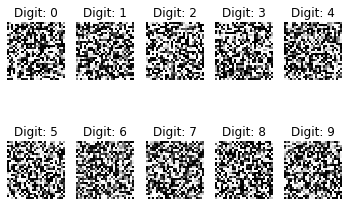

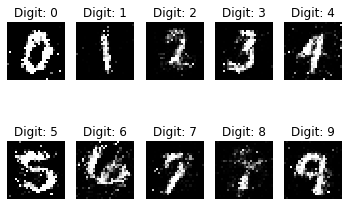

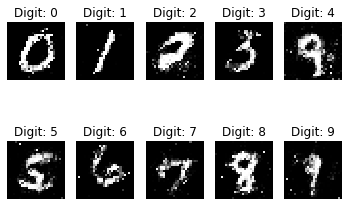

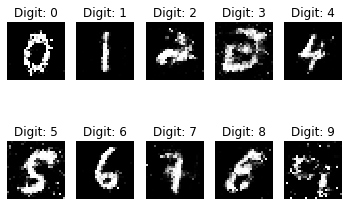

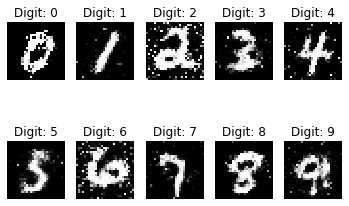

In [3]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np


# ---------------------
#  파라미터 설정, model build, compile
# ---------------------

class cGAN():
    def __init__(self):
        # input shape 설정. (mnist 이미지 크기)
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        # 0부터 9까지 10가지 분류 클래스 설정
        self.num_classes = 10
        # 노이즈의 dimension
        self.latent_dim = 100
        
        optimizer = Adam(0.0002, 0.5)
        
        # discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                  optimizer = optimizer,
                                  metrics = ['accuracy'])
        
        # generator 모델 생성
        self.generator = self.build_generator()
        
        # generator에 noise, 라벨값(0부터 9까지) 넣어줌.(라벨값에 해당하는 이미지 생성)
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
        self.discriminator.trainable = False
        
        # discriminator에 이미지와 라벨을 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
        validity = self.discriminator([img, label])
        
        # generator와 discriminator 모델 합침. (노이즈와 라벨이 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
        # discriminator를 속이도록 generator를 학습
        self.combined = Model([noise, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        
    # ---------------------
    #  Generator 모델 구성 (input : noise, label / output : image)
    # ---------------------    
        
    def build_generator(self):
        
        model = Sequential()
        
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
                  
        model.summary()
        
        # noise, label 텐서 생성
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        # label을 noise의 차원과 맞춰줌
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        # noise와 label을 합침(곱함) -> input으로 들어감
        model_input = multiply([noise, label_embedding])
        img = model(model_input)
        
        return Model([noise, label], img)
    
    
    # ---------------------
    #  Discriminator 모델 구성 (input : image, label / output : 판별값(0에서 1사이의 숫자))
    # ---------------------    
    
    def build_discriminator(self):
        
        model = Sequential()
        
        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        # noise, label 텐서 생성
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
                       
        # (10, (28x28)) 크기의 밀집벡터 생성 후 label과 합쳐서 Flatten함
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        # 이미지도 펼침(Flatten)
        flat_img = Flatten()(img)
                       
        # 펼친 이미지와 label embedding을 합침
        model_input = multiply([flat_img, label_embedding])
        
        # 모델에 input을 넣으면 판별값이 나옴
        validity = model(model_input)
        
        return Model([img, label], validity)
    
    
    # ---------------------
    #  학습 및 실행
    # ---------------------    
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        # mnist 데이터 셋 불러옴
        (X_train, y_train), (__, __) = mnist.load_data()
        
        # 이미지 전처리(Rescale -1 to 1), input shape(60000, 28, 28, 1)로 확장, label shape도 한 차원 늘림
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)
        
        # 정답으로 제시되는 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]
            
            # Sample noise 생성(batch_size만큼), noise를 generator에 넣어서 이미지 생성
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([noise, labels])
            
            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            
            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # 임의의 라벨을 뽑음
            sampled_labels = np.random.normal(0, 10, batch_size).reshape(-1, 1)
            
            # generator를 학습함. noise와 라벨을 넣고 generator가 생성한 이미지가 discriminator가 1이라고 판별할 수 있도록
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)
            
            # 1000 epoch마다 loss와 accracy 프린트
            if epoch % 1000 == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # save_interval(5000)마다 generator가 만든 이미지 프린트
            if epoch % sample_interval == 0:    
                self.sample_images(epoch)
                
    # 이미지 출력
    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r*c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
                       
        gen_imgs = self.generator.predict([noise, sampled_labels])
                       
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
                       
        fig, axs = plt.subplots(r,c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" %sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        
# cGAN실행
if __name__ == '__main__':
    gan = cGAN()
    gan.train(epochs=20001, batch_size=32, sample_interval=5000)